### homework5：（第4章）复现算法，并使用一些带雾图片，检验复现的效果。K. He, J. Sun and X. Tang, "Single Image Haze Removal Using Dark Channel Prior," in IEEE Transactions on Pattern Analysis and Machine Intelligence, vol. 33, no. 12, pp. 2341-2353, Dec. 2011, doi: 10.1109/TPAMI.2010.168.

In [1]:
import cv2;
import math;
import numpy as np;
import matplotlib.pyplot as plt

In [2]:
def darkchannel(im,sz):    #暗通道：min窗口{min_c{Ic}}
    dc=np.min(im,2)  #暗图
    DC = cv2.erode(dc,np.ones((sz,sz)))  #最小值滤波得到暗通道图，r是窗口半径
    return DC

In [3]:
def Alight1(im,DC):  #大气光成分A：借助暗通道，从有雾图中取值
    #1.暗通道中按照亮度的大小取前0.1%的像素的位置；
    [h,w] = im.shape[:2]
    sz = h*w
    n = int(max(math.floor(sz/1000),1))
    DCv = DC.reshape(sz);
    imv = im.reshape(sz,3);
    ind = (DCv.argsort())[sz-n::];  #从小到大排序后的索引值,取后num个值的位置
    
    #在原始有雾图像中寻找对应的最亮的值
    A = np.zeros([1,3])
    A[0][0] = np.max(imv[ind][0])
    A[0][1] = np.max(imv[ind][1])
    A[0][2] = np.max(imv[ind][2])

    return A 

In [4]:
def Alight2(im,DC):  #大气光成分A：借助暗通道，从有雾图中取值
    #1.暗通道中按照亮度的大小取前0.1%的像素的位置；
    [h,w] = im.shape[:2]
    sz = h*w
    n = int(max(math.floor(sz/1000),1))
    DCv = DC.reshape(sz);
    imv = im.reshape(sz,3);
    ind = (DCv.argsort())[sz-n::];  #从小到大排序后的索引值,取后num个值的位置

    #2，在原始有雾图像中寻找对应的值,取均值
    A = np.zeros([1,3])
    for i in range(1,n):
       A = A + imv[ind[i]]
    A = A / n; 

    return A 

In [5]:
def Alight3(im):  #大气光成分A :照亮度的大小取前0.1%的像素的平均值
    mean_perpix = np.mean(im, axis = 2).reshape(-1)
    mean_topper = mean_perpix[:int(im.shape[0] * im.shape[1] * 0.001)]
    A = np.ones([1,3])*np.mean(mean_topper)
    return A 

In [6]:
def Transmittanceestimate(im,A,sz): #透射率：
    w = 0.95;
    img = np.zeros(im.shape);
    for ind in range(0,3):
        img[:,:,ind] = im[:,:,ind]/A[0,ind]

    t = 1 - w*darkchannel(img,sz); #t=1-w*min窗口{min_c{Ic/Ac}}
    return t

In [7]:
def Guidedfilter(im_gray,p,r,eps):  #引导滤波(I-灰度图/255;p-t)
    im=im_gray
    mean_I = cv2.boxFilter(im,cv2.CV_64F,(r,r));
    mean_p = cv2.boxFilter(p, cv2.CV_64F,(r,r));
    mean_II = cv2.boxFilter(im*im,cv2.CV_64F,(r,r));
    mean_Ip = cv2.boxFilter(im*p,cv2.CV_64F,(r,r));
    
    var_I   = mean_II - mean_I*mean_I;
    cov_Ip = mean_Ip - mean_I*mean_p;

    a = cov_Ip/(var_I + eps);
    b = mean_p - a*mean_I;

    mean_a = cv2.boxFilter(a,cv2.CV_64F,(r,r));
    mean_b = cv2.boxFilter(b,cv2.CV_64F,(r,r));

    q = mean_a*im + mean_b;
    return q;

In [8]:
def Recover(im,t,A,tx):  #去雾图J=(I-A)/max(t,t0)+A
    J = np.zeros(im.shape);
    t = cv2.max(t,tx);

    for ind in range(0,3):
        J[:,:,ind] = (im[:,:,ind]-A[0,ind])/t + A[0,ind]

    return J

In [11]:
I = cv2.imread('./wu.png')
im = I.astype('float64')/255
im_gray= cv2.cvtColor(I, cv2.COLOR_BGR2GRAY).astype('float64')/255

DC = darkchannel(im,15); #暗通道
A1 = Alight1(im,DC);  #大气光成分A
A2 = Alight2(im,DC);
A3 = Alight3(im);
te1 = Transmittanceestimate(im,A1,15);  #根据A1的透射率t估计值
te2 = Transmittanceestimate(im,A2,15);  #A2的透射率t估计值
te3 = Transmittanceestimate(im,A3,15);  #A2的透射率t估计值
t1 = Guidedfilter(im_gray,te1,20,0.0001);  #用引导滤波获得更加完善的t1 
t2 = Guidedfilter(im_gray,te2,20,0.0001);  #用引导滤波获得更加完善的t2 
t3 = Guidedfilter(im_gray,te3,20,0.0001);  #用引导滤波获得更加完善的t3 
J1 = Recover(im,t1,A1,0.25);  #去雾图J
J2 = Recover(im,t2,A2,0.25);
J3 = Recover(im,t3,A3,0.25);
J4 = Recover(im,t3,A3,0.1);

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


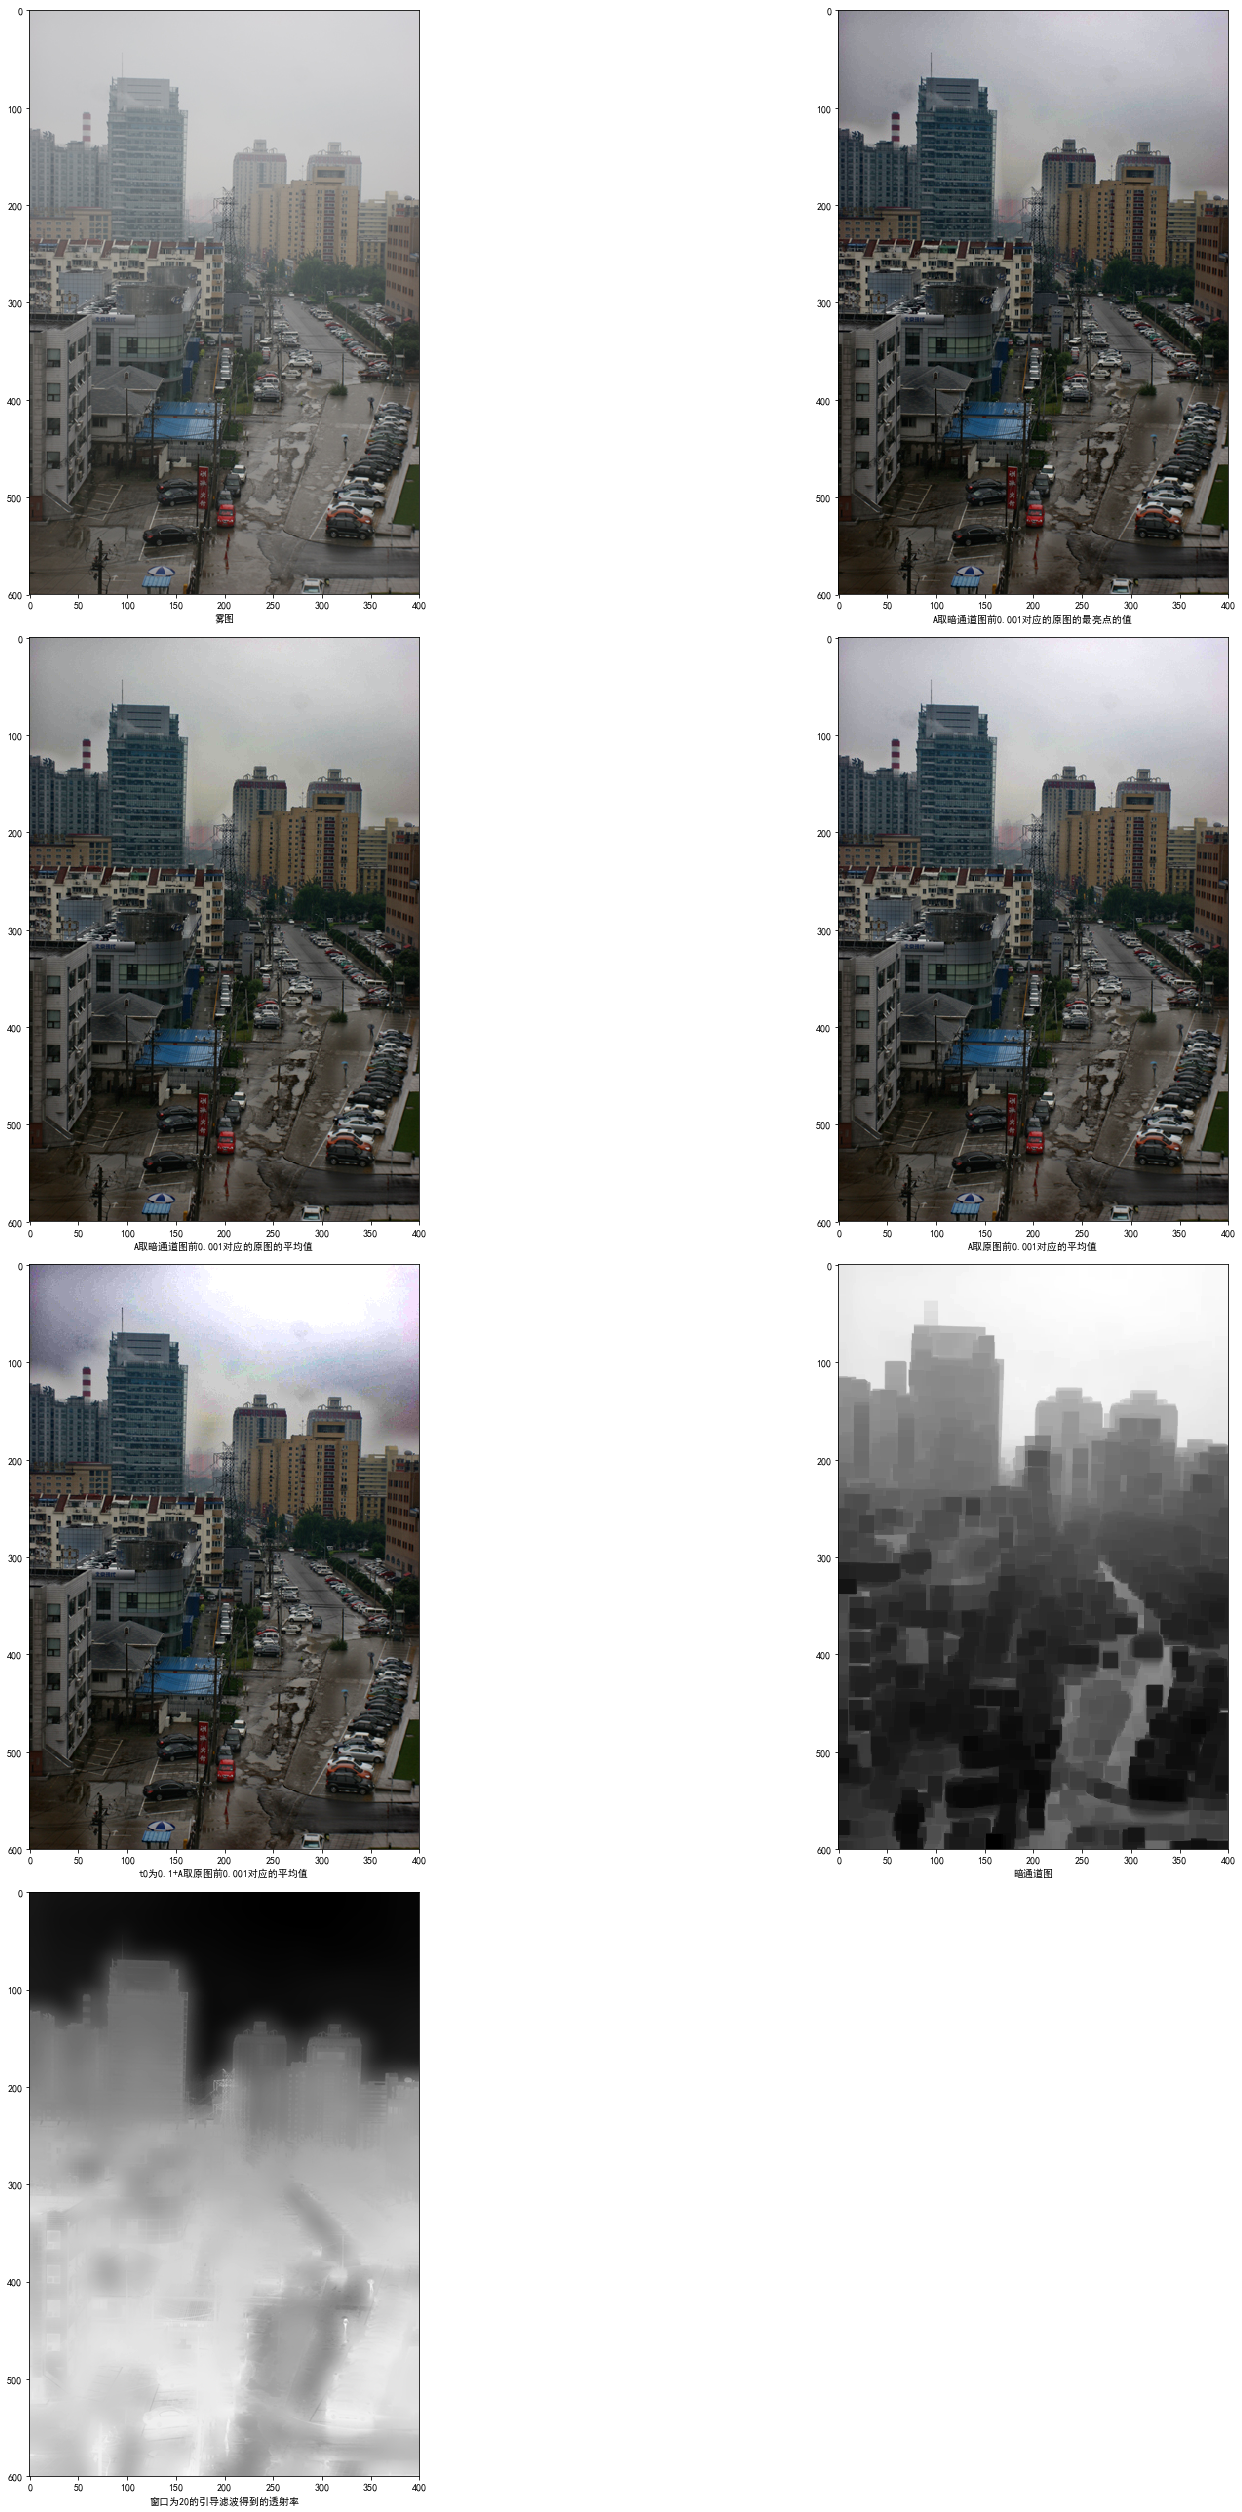

In [13]:
plt.figure(figsize=(25,35))
plt.rcParams['font.sans-serif']=['SimHei'] #显示中文标签
plt.subplot(421), plt.imshow(I[:,:,[2,1,0]]),plt.xlabel('a. 雾图')
plt.subplot(422), plt.imshow(J1[:,:,[2,1,0]]),plt.xlabel('b. A取暗通道图前0.001对应的原图的最亮点的值')
plt.subplot(423), plt.imshow(J2[:,:,[2,1,0]]),plt.xlabel('c. A取暗通道图前0.001对应的原图的平均值')
plt.subplot(424), plt.imshow(J3[:,:,[2,1,0]]),plt.xlabel('d. A取原图前0.001对应的平均值')
plt.subplot(425), plt.imshow(J4[:,:,[2,1,0]]),plt.xlabel('e. t0为0.1+A取原图前0.001对应的平均值')
plt.subplot(426), plt.imshow(DC,cmap='gray'),plt.xlabel('f. 暗通道图')
plt.subplot(427), plt.imshow(t1,cmap='gray'),plt.xlabel('g. 窗口为20的引导滤波得到的透射率')
plt.tight_layout()
plt.show()

#可以看出b,c,d三种不同求A的方法中，d不用暗通道图而直接用雾图的前0.001对应的平均值的天空效果最好。
#d和e相比，不同于t0的选择，e的天空的色斑明显。